# Assignment

In [5]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from collections import deque
import random


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [6]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

In [7]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT

    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [3 0 0 0]
 [0 0 2 0]
 [0 0 0 1]]
check?  0
dofk2  1

[[0 0 0 0]
 [0 0 0 2]
 [0 3 0 0]
 [0 0 0 1]]
0  0
check?  0
dofk2  2

[[0 0 0 0]
 [0 0 0 2]
 [3 0 0 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  2

[[0 0 0 0]
 [0 0 2 0]
 [0 0 0 1]
 [0 3 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [2 0 0 0]
 [0 0 0 1]
 [0 3 0 0]]
0.0  1
check?  0
dofk2  0


In [8]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a_base,_=np.where(allowed_a==1)
        
        a_agent_base=np.random.permutation(a_base)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent_base)
                
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.196 Number of steps:  7.338


## Agent

In [63]:
class GeneralAgent:

    def build_model(self):
        model = keras.Sequential()
        model.add(keras.layers.Dense(200, input_shape=(np.shape(X)), activation='relu'))
        model.add(keras.layers.Dense(32, activation='linear'))
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

    
    def epsilon_greedy(self, X, allowed_a, epsilon):
        allowed_ind,_=np.where(allowed_a==1)

        rand_value=np.random.uniform(0,1)

        if rand_value < epsilon:
            a = np.random.choice(allowed_ind)
        else:
            X_reshape = np.reshape(X, (1, self.N_in))
            predicted = self.model.predict(X_reshape)
            predicted_allowed = np.take(predicted, allowed_ind)
            a_p = np.argmax(predicted_allowed)
            a = allowed_ind[a_p]

        return a

    
    def load(self, name):
        self.model.load_weights(name)
    
    def save(self, name):
        self.model.save_weights(name)
        

## Task 3: SARSA

**Agent for SARSA**

In [64]:
class SarsaAgent(GeneralAgent):
    def __init__(self, N_a, N_in):
        # SAVING VARIABLES
        # initialize parameters
        self.N_a = N_a
        self.N_in = N_in

        self.epsilon = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
        self.epsilon_min = 0.01
        self.beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
        self.gamma = 0.85        # THE DISCOUNT FACTOR
        self.eta = 0.0035        # THE LEARNING RATE

        self.R_save = np.zeros([N_episodes])
        self.N_moves_save = np.zeros([N_episodes])

        self.model = self.build_model()

    def train_model(self, X, a, R, X_next, a_next, Done):        
        target = R
        X_reshape = np.reshape(X, (1, N_in))
        target_f = self.model.predict(X_reshape)

        if Done == 0:
            target = (R + self.gamma * self.model.predict(np.array([X_next]))[0])[a_next]

        target_f[0][a] = target
        self.model.fit(X_reshape, target_f, epochs=1, verbose=0)


**SARSA algorithm**

In [ ]:
# SARSA

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0]
N_episodes = 5000
sarsa_agent = SarsaAgent(N_a, N_in)
max_T = 200

for n in range(N_episodes):
    epsilon = sarsa_agent.epsilon / (1 + sarsa_agent.beta * n)
    Done = 0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    
    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME

    a = sarsa_agent.epsilon_greedy(X, allowed_a, epsilon)   #make an action

    time = 1
    
    while Done == 0:
        # take action a
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a)  
        if time == max_T:
            Done = 1    
        if Done == 0:
            a_next = sarsa_agent.epsilon_greedy(X_next, allowed_a_next, epsilon) #make an action
        sarsa_agent.train_model(X, a, R, X_next, a_next, Done)

        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done == 1:
            sarsa_agent.R_save[n] = np.copy(R)
            sarsa_agent.N_moves_save[n] = np.copy(time)
            print("episode: {}/{}, moves average: {}, reward average: {}"
                  .format(n, N_episodes,  sarsa_agent.N_moves_save[n-100:n].mean() if n > 100 else 0, 
                          sarsa_agent.R_save[n-100:n].mean() if n > 100 else 0))
            break
        
        
        X = X_next
        allowed_a = allowed_a_next
        a = a_next
        time += 1
        # if n % 100:
        #    agent.save("sarsachess")

## Task 5: Deep Q-Learning 

**Deep Q-Learning Agent**

In [67]:
class DQNAgent(GeneralAgent):
    def __init__(self, N_a, N_in):
        # SAVING VARIABLES
        # initialize parameters
        self.N_a = N_a
        self.N_in = N_in

        self.epsilon = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
        self.epsilon_min = 0.01
        self.beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
        self.gamma = 0.85        # THE DISCOUNT FACTOR
        self.eta = 0.0035        # THE LEARNING RATE

        self.R_save = np.zeros([N_episodes])
        self.N_moves_save = np.zeros([N_episodes])

        self.model = self.build_model()

        self.memory = deque(maxlen=2000)
        self.batch_size = 32

    def train_model(self):
        target = R
        if Done == 0:
            target = (R + self.gamma *
                        np.amax(self.model.predict(np.array([X_next]))[0]))
        X_reshape = np.reshape(X, (1, N_in))
        target_f = self.model.predict(X_reshape)
        target_f[0][a] = target
        self.model.fit(X_reshape, target_f, epochs=1, verbose=0)

    def replay(self): 
        minibatch = random.sample(self.memory, self.batch_size)
        for X, a, R, X_next, Done in minibatch:
            self.train_model()

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


**Training Q-Learning algorithm with Experience Replay**

In [ ]:
# Q_Learning

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_episodes = 5000
q_agent = DQNAgent(N_a, N_in)

n_steps = 0
max_T = 200

for e in range(N_episodes):
    epsilon = q_agent.epsilon / (1 + q_agent.beta * e)
    Done = 0
    S, X, allowed_a = env.Initialise_game() # select state X randomly
    time = 1

    while Done == 0:
        a = q_agent.epsilon_greedy(X, allowed_a, epsilon) #choose a from X 
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a) # take action
        q_agent.memorize(X, a, R, X_next, Done) # append results to memory

        if time == max_T:
            Done = 1

        if len(q_agent.memory) > q_agent.batch_size and n_steps%100 == 0:
            q_agent.train_model()

        if Done == 1:
            q_agent.R_save[e] = np.copy(R)
            q_agent.N_moves_save[e] = np.copy(time)
            print("episode: {}/{}, moves average: {}, reward average: {}"
                  .format(e, N_episodes,  q_agent.N_moves_save[e-100:e].mean() if e > 100 else 0, 
                          q_agent.R_save[e-100:e].mean() if e > 100 else 0))
            break

        X = X_next
        allowed_a = allowed_a_next
        time += 1
        n_steps += 1


    #if e % 10 == 0:
        #qagent.save("testchess.h5")

**Training Q-Learning algorithm without Experience Replay**

In [ ]:
# Q_Learning without replay

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_episodes = 5000
qlearning_agent = DQNAgent(N_a, N_in)

n_steps = 0
max_T = 200

for e in range(N_episodes):
    epsilon = qlearning_agent.epsilon / (1 + qlearning_agent.beta * e)
    Done = 0
    S, X, allowed_a = env.Initialise_game() # select state X randomly
    time = 1

    while Done == 0:
        a = qlearning_agent.epsilon_greedy(X, allowed_a, epsilon) #choose a from X 
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a) # take action

        if time == max_T:
            Done = 1

        qlearning_agent.train_model()

        if Done == 1:
            qlearning_agent.R_save[e] = np.copy(R)
            qlearning_agent.N_moves_save[e] = np.copy(time)
            print("episode: {}/{}, moves average: {}, reward average: {}"
                  .format(e, N_episodes,  qlearning_agent.N_moves_save[e-100:e].mean() if e > 100 else 0, 
                          qlearning_agent.R_save[e-100:e].mean() if e > 100 else 0))
            break

        X = X_next
        allowed_a = allowed_a_next
        time += 1
        n_steps += 1


    #if e % 10 == 0:
        #qagent.save("testchess.h5")

## Plots

In [78]:
# create a dataframe
df_n_moves_qlearning = pd.DataFrame({'moves': qlearning_agent.N_moves_save})
df_n_moves_sarsa = pd.DataFrame({'moves': sarsa_agent.N_moves_save})
df_n_moves_qlearning_replay = pd.DataFrame({'moves': q_agent.N_moves_save})

df_reward_qlearning = pd.DataFrame({'rewards': qlearning_agent.R_save})
df_reward_sarsa = pd.DataFrame({'rewards': sarsa_agent.R_save})
df_reward_qlearning_replay = pd.DataFrame({'rewards': q_agent.R_save})
 
# finding EMA
ema_n_moves_qlearning = df_n_moves_qlearning.ewm(com=5000).mean()
ema_n_moves_sarsa = df_n_moves_sarsa.ewm(com=5000).mean() 
ema_n_moves_qlearning_replay = df_n_moves_qlearning_replay.ewm(com=5000).mean()

ema_reward_qlearning = df_reward_qlearning.ewm(com=1000).mean()
ema_reward_sarsa = df_reward_sarsa.ewm(com=5000).mean()
ema_reward_qlearning_replay = df_reward_qlearning_replay.ewm(com=1000).mean()

# plotting color
sarsa_color = "blue"
qlearning_color = "green"
qlearning_replay_color = "lightgreen"

### Number of Moves per Game vs Training Time
**Q Learning**

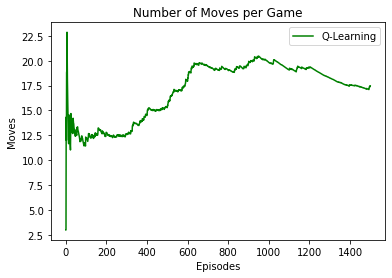

In [59]:
plt.plot(ema_n_moves_qlearning[:1500], label="Q-Learning", color=qlearning_color)
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.title("Number of Moves per Game")
plt.legend()
plt.savefig("moves_qlearning.pdf")
plt.show()

**SARSA**

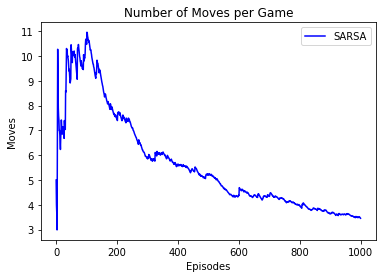

In [24]:
plt.plot(ema_n_moves_sarsa[:1000], label="SARSA", color=sarsa_color)
plt.xlabel("Episodes")
plt.ylabel("Moves")
plt.title("Number of Moves per Game")
plt.legend()
plt.savefig("moves_sarsa.pdf")
plt.show()

**Comparison**

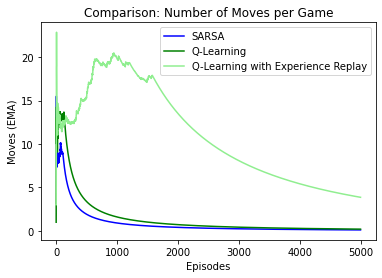

In [75]:
plt.plot(ema_n_moves_sarsa, label="SARSA", color=sarsa_color)
plt.plot(ema_n_moves_qlearning, label="Q-Learning", color=qlearning_color)
plt.plot(ema_n_moves_qlearning_replay, label="Q-Learning with Experience Replay", color=qlearning_replay_color)
plt.xlabel("Episodes")
plt.ylabel("Moves (EMA)")
plt.title("Comparison: Number of Moves per Game")
plt.legend()
plt.savefig("moves_comparison.pdf")
plt.show()

### Reward per game vs training time
**Q Learning**

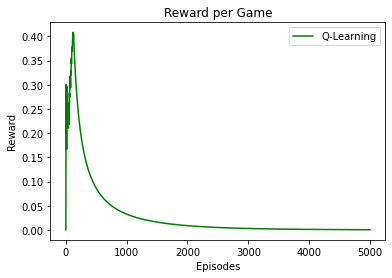

In [72]:
plt.plot(ema_reward_qlearning, label="Q-Learning", color=qlearning_replay_color)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward per Game")
plt.legend()
plt.savefig("reward_qlearning.pdf")
plt.show()

**SARSA**

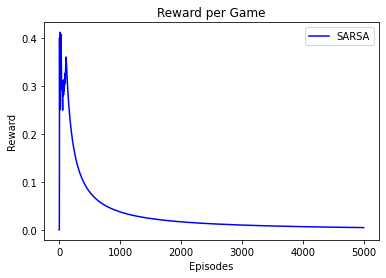

In [73]:
plt.plot(ema_reward_sarsa, label="SARSA", color=sarsa_color)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Reward per Game")
plt.legend()
plt.savefig("reward_sarsa.pdf")
plt.show()

**Comparison**

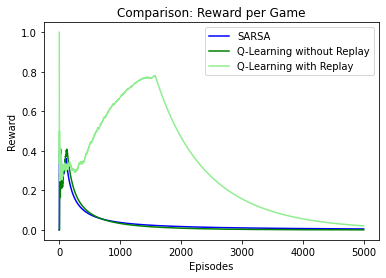

In [80]:
plt.plot(ema_reward_sarsa, label="SARSA", color=sarsa_color)
plt.plot(ema_reward_qlearning, label="Q-Learning without Replay", color=qlearning_color)
plt.plot(ema_reward_qlearning_replay, label="Q-Learning with Replay", color=qlearning_replay_color)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Comparison: Reward per Game")
plt.legend()
plt.savefig("reward_comparison.pdf")
plt.show()

# Obsolete

In [ ]:
# SAVING VARIABLES
# initialize parameters
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
#memory = deque(maxlen=2000)
n_steps = 0

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE

Qtable = np.random.randn(1, N_a)/1000

R_Sarsa = np.zeros([N_episodes])
N_moves_Sarsa = np.zeros([N_episodes])

In [ ]:
def greedyReshaped(model, X, epsilon, allowed_a):
    allowed_ind,_=np.where(allowed_a==1)

    rand_value=np.random.uniform(0,1)

    if rand_value < epsilon:
        a = np.random.choice(allowed_ind)
    else:
        import pdb;
        #pdb.set_trace();
        X_reshape = np.reshape(X, (1, N_in))
        predicted = model.predict(X_reshape)
        predicted_allowed = np.take(predicted, allowed_ind)
        a_p = np.argmax(predicted_allowed)
        a = allowed_ind[a_p]

    return a

In [ ]:
import random

def replaySarsa(model, batch_size):
    minibatch = random.sample(memory, batch_size)
    for X, a, a_next, R, X_next, Done in minibatch:
        target = R
        if Done == 0:
            target = (R + gamma * model.predict(np.array([X_next]))[0])[a_next]
        X_reshape = np.reshape(X, (1, N_in))
        target_f = model.predict(X_reshape)
        target_f[0][a] = target
        model.fit(X_reshape, target_f, epochs=1, verbose=0)

**SARSA with memory**

In [ ]:
# SARSA

# SAVING VARIABLES
# initialize parameters
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
memory = deque(maxlen=2000)

S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

R_Sarsa = np.zeros([N_episodes])
N_moves_Sarsa = np.zeros([N_episodes])

model = build_model()
batch_size = 32

for n in range(N_episodes):

    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    
    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
    epsilon_f = epsilon_0
    a = greedyReshaped(model, X, epsilon_f, allowed_a)   #make an action
    
    for time in range(max_T):
        # take action a
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a)
        R_Sarsa[n] += np.copy(R)
        N_moves_Sarsa[n] = np.copy(time+1)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            print("episode: {}/{}, score: {}, reward average: {}"
                  .format(n, N_episodes,  N_moves_Sarsa[n], R_Sarsa[n-100:n].mean() if n > 100 else 0))
            break
            
        # chose a with epsilon greedy
        a_next = greedyReshaped(model, X_next, epsilon_f, allowed_a_next) #make an action
        memory.append((X, a, a_next, R, X_next, Done))
        
        if len(memory) > batch_size and (time+1)%100 == 0:
            replaySarsa(model, batch_size)
        
        X = X_next
        allowed_a = allowed_a_next
        a = a_next